In [2]:
!pip install eli5

In [3]:
import pandas as pd
import gensim
import numpy as np
import matplotlib.pyplot as plt
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.model_selection import train_test_split
from string import punctuation
from sklearn.model_selection import KFold, train_test_split
from collections import Counter
import gensim
import tensorflow as tf
from sklearn.metrics import *
from sklearn import linear_model
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
import gensim.downloader as api

import re 
from string import punctuation as punct

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [3]:
from google.colab import drive 
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [8]:
gdrive = '/gdrive/My Drive/'
path = gdrive + "jigsaw-toxic-comment-train.csv"
quora = pd.read_csv(path)

In [9]:
quora.size

1788392

In [10]:
quora = quora.sample(frac=0.5, random_state=42)

In [7]:
quora.size

894192

##Анализ всех дополнительных колонок тональности (как проявляется тот или иной тип токсичности, как в данных это представлено, какие есть пограничные случаи) - 2.5 балла

In [10]:
quora.corr()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
toxic,1.000000,0.287592,0.696539,0.155648,0.665785,0.273658
severe_toxic,0.287592,1.000000,0.370873,0.119363,0.341412,0.200105
obscene,0.696539,0.370873,1.000000,0.132644,0.740350,0.289751
threat,0.155648,0.119363,0.132644,1.000000,0.143322,0.094517
insult,0.665785,0.341412,0.740350,0.143322,1.000000,0.339152
identity_hate,0.273658,0.200105,0.289751,0.094517,0.339152,1.000000


1) Токсичность комментариев больше всего коррелирует с обсценной лексикой и оскорблениями. Наименьшая корреляция с угрозами.
2) У "острой токсичности" (severe_toxic) корреляции выглядят похоже, но с более низкими значениями. 
3) Обсценная лексика больше всего коррелирует с оскорблениями и токсичностью, в меньшей степени - с угрозами. 
4) Угрозы коррелируют со всеми показателями похожим образом незначительно (но в наибольшей степени - с токсичностью). 
5) Оскорбления коррелируют больше всего с обсценной лексикой и токсичностью, а меньше всего - с угрозами. 
6) Ненависть к социальным группам больше всего коррелирует с оскорблениями, 
обсценной лексикой и токсичностью, однако значение корреляции меньше, чем у корреляции большинства предыдущих метрик между собой.

In [ ]:
quora.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,223549.000000,223549.000000,223549.000000,223549.000000,223549.000000,223549.000000
mean,0.095657,0.008777,0.054306,0.003082,0.050566,0.009470
std,0.294121,0.093272,0.226621,0.055431,0.219110,0.096852
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Наибольшее среднее значение у токсичных комментариев и комментариев, содержащих обсценную лексику и оскорбления. Наибольшее среднеквадратическое отклонение также у токсичности, обсценной лексики и оскорблений.

###Функции для подсчета статистик

Некоторые идеи(функцию raw_text) подсмотрел здесь: https://github.com/lwahomura/ML/blob/master/Exam_sharing.ipynb

In [8]:
def raw_text(text): # without meta symbols
  text = re.sub("\n|\t|\s\"", " ", text)
  return text

In [9]:
def digits(text):
  d = re.findall('[1-9]', text)
  return len(d) 


def digits_ratio(text):
  ratio = digits(text)/len(raw_text(text))
  return ratio


def new_lines(text):
  all_new_lines = re.findall('\n', text) 
  return len(all_new_lines)


def words_numb(text):
  tokenized = raw_text(text).split()
  return len(tokenized)


def words_mean_len(text):
  tokenized = raw_text(text).split()
  n, token_sum = 0, 0
  for token in tokenized:
    n+=1
    token_sum += len(token)
  return token_sum/n


def punct_numb(text):
  all_punct = [ch for ch in text if ch in punct]
  return len(all_punct)


def caps_numb(text):
  all_caps = [ch for ch in text if ch.isupper()]
  return len(all_caps)


def caps_ratio(text):
  ratio = caps_numb(text)/len(raw_text(text))
  return ratio


def no_latin(text):
  no_latin = re.findall('[^a-zA-Z]', text)
  return len(no_latin)


def no_latin_ratio(text):
  ratio = no_latin(raw_text(text))/len(raw_text(text))
  return ratio



In [11]:
quora['length'] = quora.comment_text.apply(len)
quora['digits_numb'] = quora.comment_text.apply(digits)
quora['digits_ratio'] = quora.comment_text.apply(digits_ratio)
quora['lines'] = quora.comment_text.apply(new_lines)
quora['words_numb'] = quora.comment_text.apply(words_numb)
quora['words_mean_len'] = quora.comment_text.apply(words_mean_len)
quora['punct_numb'] = quora.comment_text.apply(punct_numb)
quora['caps_numb'] = quora.comment_text.apply(caps_numb)
quora['caps_ratio'] = quora.comment_text.apply(caps_ratio)
quora['no_latin_number'] = quora.comment_text.apply(no_latin)
quora['no_latin_ratio'] = quora.comment_text.apply(no_latin_ratio)

###Анализ колонок тональности по-отдельности

####toxic

In [316]:
quora.groupby('toxic')['length', 'digits_numb', 'digits_ratio', 'lines', 'words_numb', 'words_mean_len', 
                      'punct_numb', 'caps_numb', 'caps_ratio', 'no_latin_number', 'no_latin_ratio'].agg(['mean'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,length,digits_numb,digits_ratio,lines,words_numb,words_mean_len,punct_numb,caps_numb,caps_ratio,no_latin_number,no_latin_ratio
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
toxic,,,,,,,,,,,
0,403.232954,2.629527,0.008996,2.622802,68.226446,4.966202,17.017615,14.637203,0.045710,93.537604,0.241248
1,281.940289,1.556899,0.008022,2.141826,48.719348,5.062140,13.837739,44.491657,0.111537,66.959130,0.246807


Для токсичных и нетоксичных комментариев мы можем наблюдать следующие закономерности:
1) Токсичные комментарии в среднем значительно короче (по символам)
2) В токсичных комментариях меньше цифр
3) Доля цифр в токсичных комментариях также меньше
4) В токсичных текстах меньшее число переводов строк 
5) Нетоксичные тексты многословнее
6) Средняя длина слова сопоставима, но в токсичных комментариях все же немного больше
7) В нетоксичных комментариях больше знаков пунктуации
8) В ТОКСИЧНЫХ ТЕКСТАХ ЗНАЧИТЕЛЬНО БОЛЬШЕ СИМВОЛОВ В ВЕРХНЕМ РЕГИСТРЕ (в 3 раза)
9) Доля символов в верхнем регистре соответственно тоже больше в токсичных текстах
10) Нелатинские символы в среднем чаще встречаются в нейтральных текстах
11) При этом доля нелатинских символов, наоборот, немного выше в токсичных текстах

####severe_toxic

In [317]:
quora.groupby('severe_toxic')['length', 'digits_numb', 'digits_ratio', 'lines', 'words_numb', 'words_mean_len', 
                      'punct_numb', 'caps_numb', 'caps_ratio', 'no_latin_number', 'no_latin_ratio'].agg(['mean'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,length,digits_numb,digits_ratio,lines,words_numb,words_mean_len,punct_numb,caps_numb,caps_ratio,no_latin_number,no_latin_ratio
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
severe_toxic,,,,,,,,,,,
0,390.598563,2.535815,0.008921,2.565948,66.200060,4.958836,16.589331,16.115940,0.050661,90.718538,0.241723
1,512.880041,1.534643,0.006851,3.831437,85.223371,6.868614,31.013444,174.547053,0.204576,123.354705,0.248146


Для очень токсичных комментариев и комментариев со значением severe_toxic=0 мы можем наблюдать следующие закономерности:
1) Очень токсичные комментарии в среднем значительно длиннее по символам
2) В очень токсичных комментариях меньше цифр
3) Доля цифр в очень токсичных комментариях также меньше
4) В очень токсичных текстах большее число переводов строк 
5) Очень токсичные тексты многословнее
6) Средняя длина слова больше в очень токсичных комментариях
7) В очень токсичных комментариях больше знаков пунктуации
8) В очень токсичных комментариях в 10 раз больше букв в верхнем регистре
9) Доля символов в верхнем регистре соответственно тоже больше в очень токсичных текстах (в 4 раза)
10) Нелатинские символы в среднем чаще встречаются в очень токсичных текстах
11) При этом доля нелатинских символов сопоставими, но немного больше в очень токсичных текстах

####obscene

In [13]:
quora.groupby('obscene')['length', 'digits_numb', 'digits_ratio', 'lines', 'words_numb', 'words_mean_len', 
                      'punct_numb', 'caps_numb', 'caps_ratio', 'no_latin_number', 'no_latin_ratio'].agg(['mean'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,length,digits_numb,digits_ratio,lines,words_numb,words_mean_len,punct_numb,caps_numb,caps_ratio,no_latin_number,no_latin_ratio
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
obscene,,,,,,,,,,,
0,397.609200,2.566141,0.008927,2.592839,67.342614,4.953150,16.838666,15.376557,0.047871,92.280479,0.241347
1,287.395395,1.844294,0.008484,2.297664,49.235547,5.364332,14.532715,54.443432,0.124190,68.589034,0.249340


Для комментариев с обсценной лексикой и без(обычных) мы можем наблюдать следующие закономерности:
1) Обычные комментарии в среднем значительно длиннее по символам
2) В обычных комментариях больше цифр
3) Доля цифр в обычных комментариях также немного больше
4) В обычных текстах большее число переводов строк 
5) Тексты без обсценной лексики многословнее
6) Средняя длина слова больше в комментариях с обсценной лексикой
7) Пунктуации больще в обычных комментариях
8) Букв в верхнем регистре больше в комментариях с обсценной лексикой
9) Доля таких букв тоже больше в комментариях с обсценной лексикой
10) Нелатинские символы в среднем чаще встречаются в текстах без обсценной лексики
11) При этом доля нелатинских символов выше в текстах с обсценной лексикой

####threat

In [14]:
quora.groupby('threat')['length', 'digits_numb', 'digits_ratio', 'lines', 'words_numb', 'words_mean_len', 
                      'punct_numb', 'caps_numb', 'caps_ratio', 'no_latin_number', 'no_latin_ratio'].agg(['mean'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,length,digits_numb,digits_ratio,lines,words_numb,words_mean_len,punct_numb,caps_numb,caps_ratio,no_latin_number,no_latin_ratio
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
threat,,,,,,,,,,,
0,391.832811,2.532563,0.008915,2.577458,66.385247,4.975970,16.713236,17.270552,0.051695,91.030917,0.241753
1,328.859425,0.600639,0.004625,2.376997,59.025559,4.757471,17.028754,94.418530,0.158096,80.306709,0.251051


Для комментариев с угрозами и без(обычных) мы можем наблюдать следующие закономерности:
1) Длина текстов ближе, чем в других парах. Комментарии с угрозами все равно длиннее.
2) В обычных комментариях больше цифр
3) Доля цифр в обычных комментариях также немного больше
4) В обычных текстах большее число переводов строк 
5) Тексты без угроз многословнее
6) Средняя длина слов сопоставима, но больше в текстах без угроз
7) Пунктуации почти одинаковая, немного больше ее в текстах с угрозами
8) Букв в верхнем регистре больше в комментариях с угрозами(в несколько раз)
9) Доля таких букв тоже больше в комментариях с угрозами
10) Нелатинские символы в среднем чаще встречаются в текстах без угроз
11) При этом доля нелатинских символов выше в текстах с угрозами

####insult 	

In [15]:
quora.groupby('insult')['length', 'digits_numb', 'digits_ratio', 'lines', 'words_numb', 'words_mean_len', 
                      'punct_numb', 'caps_numb', 'caps_ratio', 'no_latin_number', 'no_latin_ratio'].agg(['mean'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,length,digits_numb,digits_ratio,lines,words_numb,words_mean_len,punct_numb,caps_numb,caps_ratio,no_latin_number,no_latin_ratio
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
insult,,,,,,,,,,,
0,397.738428,2.565777,0.008963,2.600317,67.355826,4.954506,16.854483,15.764177,0.048343,92.314748,0.241566
1,277.098669,1.799645,0.007762,2.135759,47.694942,5.368130,14.070275,49.929370,0.120739,66.253416,0.245784


Для комментариев с оскорблениями и без(обычных) мы можем наблюдать следующие закономерности:
1) Посимвольная длина больше в текстах без оскорблений
2) В обычных комментариях больше цифр
3) Доля цифр в обычных комментариях также немного больше
4) В обычных текстах большее число переводов строк 
5) Тексты без оскорблений многословнее
6) Средняя длина слов сопоставима, но больше в текстах с оскорблениями
7) Больше пунктуации в текстах без оскорблений
8) Букв в верхнем регистре больше в комментариях с оскорблениями(в несколько раз)
9) Доля таких букв тоже больше в комментариях с оскорблениями
10) Нелатинские символы в среднем чаще встречаются в текстах без оскорблений
11) При этом доля нелатинских символов похожа, немного выше она в текстах с оскорблениями

####identity_hate

In [16]:
quora.groupby('identity_hate')['length', 'digits_numb', 'digits_ratio', 'lines', 'words_numb', 'words_mean_len', 
                      'punct_numb', 'caps_numb', 'caps_ratio', 'no_latin_number', 'no_latin_ratio'].agg(['mean'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,length,digits_numb,digits_ratio,lines,words_numb,words_mean_len,punct_numb,caps_numb,caps_ratio,no_latin_number,no_latin_ratio
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
identity_hate,,,,,,,,,,,
0,392.386404,2.531178,0.008921,2.575999,66.505508,4.957957,16.761855,16.985689,0.051121,91.217423,0.241801
1,312.554795,2.090998,0.006898,2.674168,51.098826,6.861070,11.541096,71.768102,0.146475,67.535225,0.239336


Для комментариев с ненавистью к соц. группам и без(обычных) мы можем наблюдать следующие закономерности:
1) Посимвольная длина больше в обычных текстах 
2) В обычных комментариях больше цифр
3) Доля цифр в обычных комментариях также немного больше
4) В обычных текстах меньшее число переводов строк 
5) Тексты без ненависти к соц. группам многословнее
6) Средняя длина слов больше в текстах с враждой к соц. группам
7) Больше пунктуации в обычных текстах 
8) Букв в верхнем регистре больше в комментариях с враждой к соц. группам
9) Доля таких букв тоже больше в комментариях с ненавистью к соц. группам
10) Нелатинские символы в среднем чаще встречаются в обычных текстах
11) При этом доля нелатинских символов похожа, немного выше она в обычных комментариях

###Пары целевой переменной (toxic) с другими колонками тональности

####Toxic-severe_toxic

In [26]:
quora.groupby(['toxic', 'severe_toxic'])['length', 'digits_numb', 'digits_ratio', 'lines', 'words_numb', 'words_mean_len', 
                      'punct_numb', 'caps_numb', 'caps_ratio', 'no_latin_number', 'no_latin_ratio'].agg(['mean'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


length digits_numb  ... no_latin_number no_latin_ratio
                          mean        mean  ...            mean           mean
toxic severe_toxic                          ...                               
0     0             403.232954    2.629527  ...       93.537604       0.241248
1     0             258.920111    1.559118  ...       61.337594       0.246673
      1             512.880041    1.534643  ...      123.354705       0.248146

[3 rows x 11 columns]

Мы можем наблюдать, что не бывает очень токсичных комментариев со значением toxic=0, что понятно. 

1) Наименьшая длина у просто токсичных комментариев, наибольшая - у токсичных.
2) Цифр больше в нетоксичных комментариях, у токсичных - сопоставимо
3) Наименьшая доля цифр в очень токсичных комментариях
4) Меньше всего строк в просто токсичных комментариях, а больше всего в очень токсичных
5) Меньше слов в токсичных, больше - в очень токсичных
6) Самые длинные слова в очень токсичных комментариях. В нетоксичных и просто токсичных длины слов сопоставимы
7) В очень токсичных комментариях больше знаков пунктуации (возможно "!" или "?")
8) Значительно больше слов в верхнем регистре в очень токсичных комментариях
9) Доля слов в верхнем регистре также растет со степенью токсичности
10) Меньше всего нелатинских символов в токсичных комментариях, а больше всего - в очень токсичных (возможно это какие-нибудь цензурные "*" как в "f**k")
11) Доля латинских символов сопоставима, незначительно растет со степенью токсичности

In [32]:
for text in quora[(quora['toxic']==1) & (quora['severe_toxic']==0)]['comment_text'][:3]:
  print(text)

:You might like to consider that I don't give a shit what you do or think.
Uncle Tom House Niggers
Bunch of morons should go **** themselves 

WESTBORO BAPTIST CHURCH ARE A F***** DISGRACE TO THE CHRISTIAN FAITH! HOW DARE THEY BE SO F***** SATANIC TO HOLD PROTESTS AT SOLDIERS' FUNERALS! THOSE CUNTS NEED SORTING OUT!


Если посмотреть на некоторые примеры сообщений, помеченных как токсичные (но не severe_toxic), не очень понятно почему последнее сообщение в верхнем регистре не относится к очень токсичным. Первые 3 примера токсичны, но действительно достаточно "сдержанные" и короткие.

In [33]:
for text in quora[(quora['toxic']==1) & (quora['severe_toxic']==1)]['comment_text'][:3]:
  print(text)

how bout 

you fuck off
You're not an admin 

You act like an admin, but you're not an admin. Don't even fucking act like that. You're trying to fuck me up but you can't do any shit like that. As a sofa lands on the ground, your mother gets her tits squashed and dies and a dead rabbit falls from the clouds and lands on your ass, licking your ass. User:Factual80man
CardinalDanFUCK YOU FAGGOT NIGGER CUNT LICKING CHINK DIPFUCKING SHIT NIGGER FACE, GET A LIFE OTHER THEN DELETING SHIT OFF WIKI YOU NERD FAGGOT


На этих примерах очень токсичных сообщений можно действительно убедиться, что они более многословны и в них больше переводов строк

####Toxic-obscene

In [35]:
quora.groupby(['toxic', 'obscene'])['length', 'digits_numb', 'digits_ratio', 'lines', 'words_numb', 'words_mean_len', 
                      'punct_numb', 'caps_numb', 'caps_ratio', 'no_latin_number', 'no_latin_ratio'].agg(['mean'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


length digits_numb  ... no_latin_number no_latin_ratio
                     mean        mean  ...            mean           mean
toxic obscene                          ...                               
0     0        402.834758    2.612700  ...       93.430329       0.241242
      1        541.662069    8.479310  ...      130.831034       0.243262
1     0        290.553749    1.612274  ...       68.723633       0.243490
      1        274.564816    1.509483  ...       65.448234       0.249647

[4 rows x 11 columns]

Здесь уже можно заметить, что обсценная лексика необязательно является маркером токсичности (можно вспомнить о степени табуированности такой лексики в разных культурах)

1) Интересно, что больше символов в нетоксичных сообщениях с обсценной лексикой
2) В нетоксичных сообщениях с обсценной лексикой также больше цифр (возможно их мало и это какие-то статистические выбросы)
3) Доля цифр соответственно больше в нетоксичных сообщениях с обсценной лексикой
4) Переводы строк чаще встречаются в нетоксичных сообщениях с обсценной лексикой
5) В нетоксичных сообщениях с обсценной лексикой больше слов, на втором месте - нетоксичные комментарии без ругательств
6) Наибольшая длина слов в нетоксичных текстах с ругательствами, наименьшая - в токсичных без ругательств
7) В нетоксичных сообщениях с обсценной лексикой больше пунктуации, меньше пунктуации - в токсичных без ругательств
8) Капсом чаще пишут в токсичных сообщениях с бранными словами, меньше - в обычных сообщениях (со значениями 0 и 0)
9) Доля капса больше в токсичных нежели нетоксичных текстах
10) Нелатинских символов(видимо, цифр) больше всего в нетоксичных текстах с бранью и обычных текстах
11) Доля нелатинских символов везде сопоставима

In [36]:
for text in quora[(quora['toxic']==0) & (quora['obscene']==1)]['comment_text'][:3]:
  print(text)

"
 Wow, serious stick-up-the-ass-itis. But seriously, thanks for getting me blocked. Always wanted to do it. Thought it might be fun for a while, but turns out all the admins are the same variety of lame: lazy fascist. Sound familiar? Anyway, seriously, since I'm taking a (permanent?) break from Wikipedia, just leave that info here. I'm very serious about following up on that since Frank O'Hara is a subject of research in non-toilet-backwoods-punchline style research. Ya'll have fun wasting your lives on futility while the sticks up your asses keep you from having the real kind of fun you should with crap like this. But seriously, let me know where you got that O'Hara info. I'd like to follow it up (I know you'll ignore me, it's your pattern, but thought I'd give it a try  do you need reading lessons or something, it's like you have paragraphs on auto and are unable to read what others say). Anyway, just a citation or something, ""Frank O'Hara hates beats found here:"" Citation is anot

In [37]:
len(quora[(quora['toxic']==0) & (quora['obscene']==1)])

290

In [39]:
len(quora[(quora['toxic']==1) & (quora['obscene']==1)])

5747

В примерах нетоксичных текстов с обсценной лексикой мы сразу может видеть комментарий, похожий на выброс. Он очень длинный, в нем есть цифры, а ругательства приведены в кавычках. Количество таких сообщений действительно значительно меньше, чем токсичных с обсценной лексикой

####Toxic-threat

In [40]:
quora.groupby(['toxic', 'threat'])['length', 'digits_numb', 'digits_ratio', 'lines', 'words_numb', 'words_mean_len', 
                      'punct_numb', 'caps_numb', 'caps_ratio', 'no_latin_number', 'no_latin_ratio'].agg(['mean'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


length digits_numb  ... no_latin_number no_latin_ratio
                    mean        mean  ...            mean           mean
toxic threat                          ...                               
0     0       403.268119    2.629747  ...       93.545221       0.241244
      1       129.769231    0.923077  ...       34.307692       0.272078
1     0       280.333044    1.584973  ...       66.515239       0.246710
      1       337.486667    0.586667  ...       82.300000       0.250140

[4 rows x 11 columns]

Для этой пары тональностей тоже можно сделать интересное наблюдение: бывают нетоксичные сообщения с угрозами.
1) Наименьшая посимвольная длина у нетоксичных комментариев с угрозами (возможно здесь снова выбросы). Наибольшая - у нейтральных
2) Больше всего цифр в обычных сообщениях, меньше всего в токсичных с угрозами
3) Доля цифр везде похожа, кроме токсичных комментариев с угрозами (там она меньше)
4) Меньше всего переводов строк в нетоксичных комментариях с угрозами, у остальных этот показатель похожий
5) Самые многословные комментарии - нейтральные, меньше всего слов у нетоксичных угроз (скорее всего их мало и это выбросы)
6) Меньшая длина слов в нетоксичных комментариях с угрозами, наибольшая - у токсичных без угроз
7) Меньше пунктуации в нетоксичных текстах с угрозами, похожее значение - у нейтральных и токсичных с угрозами
8) Больше всего капса у токсичных комментариев с угрозами и у токсичных без угроз. Меньше всего - у нетоксичных с угрозами
9) Доля капса растет с количеством угроз и токсичностью
10) Меньше всего нелатинсих символов в нетоксичных комментариях с угрозами, а больше всего - в обычных
11) Доля нелатинских символов сопоставимая во всех колонках

In [41]:
for text in quora[(quora['toxic']==0) & (quora['threat']==1)]['comment_text'][:3]:
  print(text)

personal attacks 

dont tell me what i can and can not do i'll come over there right now and throw a brick through ur window
I'ma smack ya upside da head wit a shovel. 

I'm takin ya down, boi.
I KNOW IT'S ENGLAND BECAUSE IT SAYS UTC 

IN FACT I'LL BLOW UP UK AND IRELAND!


In [53]:
len( quora[(quora['toxic']==0) & (quora['threat']==1)])

13

In [54]:
len( quora[(quora['toxic']==1) & (quora['threat']==1)])

300

Сложно судить, почему, например, угроза разбить окно кирпичом не является токсичной. Или "I'LL BLOW UP UK AND IRELAND" возможно кто-то трактует метафорически. "I'm takin ya down, boi" в контексте состязательного спорта не так уж и токсично. Таких сообщений(нетоксичных с угрозами) всего 13 и это явные статистические выбросы

In [43]:
for text in quora[(quora['toxic']==1) & (quora['threat']==0)]['comment_text'][:3]:
  print(text)

:You might like to consider that I don't give a shit what you do or think.
Uncle Tom House Niggers
Bunch of morons should go **** themselves 

WESTBORO BAPTIST CHURCH ARE A F***** DISGRACE TO THE CHRISTIAN FAITH! HOW DARE THEY BE SO F***** SATANIC TO HOLD PROTESTS AT SOLDIERS' FUNERALS! THOSE CUNTS NEED SORTING OUT!


Токсичные сообщения с угрозами проще представить. Они больше нацелены на оскорбление или identity hate. Примеры, это иллюстрируют

####Toxic-insult

In [44]:
quora.groupby(['toxic', 'insult'])['length', 'digits_numb', 'digits_ratio', 'lines', 'words_numb', 'words_mean_len', 
                      'punct_numb', 'caps_numb', 'caps_ratio', 'no_latin_number', 'no_latin_ratio'].agg(['mean'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


length digits_numb  ... no_latin_number no_latin_ratio
                    mean        mean  ...            mean           mean
toxic insult                          ...                               
0     0       403.304287    2.611610  ...       93.539988       0.241263
      1       380.261981    8.399361  ...       92.769968       0.236286
1     0       292.800224    1.701646  ...       69.214179       0.247268
      1       271.031379    1.411499  ...       64.693912       0.246343

[4 rows x 11 columns]

Здесь мы можем наблюдать, что бывают нетоксичные оскорбления.
1)  Посимвольная длина сообщения уменьшается по мере увеличения оскорблений и токсичности
2) Больше всего цифр в нетоксичных сообщениях (особенно в тех, что с оскорблениями)
3) Доля цифр также выше в нетоксичных сообщениях
4) Больше всего строк в обычных сообщениях. Меньше всего - в токсичных с оскорблениями
5) Число слов уменьшается по мере увеличения оскорблений и токсичности
6) Наибольшая длина слов в сообщениях с оскорблениями. Наименьшая - в токсичных без оскорблений
7) Больше всего пунктуации в нетоксичных сообщениях
8-9) Количество букв в верхнем регистре и их доля прямо пропорциональны токсичности и наличию оскорблений
10-11) Нелатинские символы чаще встречаются в нетоксичных сообщениях. Доля же таких символов сопоставима, но также меньше в нетоксичных текстах

In [45]:
for text in quora[(quora['toxic']==0) & (quora['insult']==1)]['comment_text'][:3]:
  print(text)

"

 Hindu Vandal 

YOu are a confirment Upper caste hindu vandal.  Morally corrupt as you are; you must be a Bhramin. You are a Confirmed sock puppeteer. You have been going around with another user name ""Netaji"" "
don't vandalize, please!

your reversion of my edits constitutes as vandalism, because I wasn't vandalizing myself! please don't do it again, or you may get banned.

also, just because your wife is a black latina doesn't mean yuh need to start braggin' about dat pum pum all over the place. did you marry her because you love her, or because she was a black pum pum latina? racist coward... 216.102.76.54
Dear Josiah,

2 random blaggards named Bastin and John Carter have repeatedly vandalized my page and I solemnly think it needs to stop! They keep on insulting my intelligence and from what I have heard you are a good administrator who helps people out! The best way you can help me is to block these fools immediately!

Lots of Love,
God bless,

12th Doctor


In [51]:
len(quora[(quora['toxic']==0) & (quora['insult']==1)])

313

In [52]:
len(quora[(quora['toxic']==1) & (quora['insult']==1)])

5322

Нетоксичных сообщений с оскорблениями всего 313.  В последнем автор оскорбляет кого-то в 3-м лице, кто портит его страницу, и просит о помощи. Действительно, нельзя однозначно сказать, что оно токсично. Во втором кого-то называют "racist coward". Мне кажется, это вполне токсично, но возможно всё не так однозначно. В первом случае кого-то называют вандалом и критикуют моральные качества. Наверное это может быть обидно, но всё же не совсем токсично

In [48]:
for text in quora[(quora['toxic']==1) & (quora['insult']==0)]['comment_text'][:3]:
  print(text)

Uncle Tom House Niggers
how bout 

you fuck off
Cesc Fabregas 

I see it's been changed that he now plays for Chelsea. Looks like I was right all along, how do you like that you little bitch? I was right and you were wrong.


In [58]:
len(quora[(quora['toxic']==1) & (quora['insult']==0)])

5346

Примеры иллюстрируют, что токсичные комментарии могут не содержать прямых оскорблений. Во всех них используется обсценная лексика

####Toxic-identity_hate

In [59]:
quora.groupby(['toxic', 'identity_hate'])['length', 'digits_numb', 'digits_ratio', 'lines', 'words_numb', 'words_mean_len', 
                      'punct_numb', 'caps_numb', 'caps_ratio', 'no_latin_number', 'no_latin_ratio'].agg(['mean'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


length digits_numb  ... no_latin_number no_latin_ratio
                           mean        mean  ...            mean           mean
toxic identity_hate                          ...                               
0     0              403.215713    2.629522  ...       93.535982       0.241261
      1              428.478261    2.637681  ...       95.913043       0.222899
1     0              279.760473    1.508389  ...       67.104169       0.247423
      1              304.161595    2.051417  ...       65.480588       0.240526

[4 rows x 11 columns]

Мы можем наблюдать, что identity hate может встречаться в нетоксичных сообщениях

1) Длина комментариев больше в нетоксичных текстах
2-3) Наименьшее число цифр в токсичных сообщениях. Доля же цифр значительно меньше в токсичных сообщениях с ненавистью к социальным классам
4) Наибольшее число строк в нейтральных сообщениях и в токсичных с ненавистью к классам
5) В нетоксичных комментариях больше слов
6) Самые длинные слова в комментариях с identity_hate (видимо, там чаще встречаются такие слова как "communist", "homosexual", "christian" и они обычно длиннее)
7)В нетоксичных сообщениях больше пунктуации
8-9) Число символов в верхнем регистре и их доля растут вместе с токсичностью и разжиганием ненависти
10-11)Число нелатинских символов уменьшается вместе с токсичностью. Наименьшая их доля в нетоксичных текстах с разжиганием ненависти

In [60]:
for text in quora[(quora['toxic']==0) & (quora['identity_hate']==1)]['comment_text'][:3]:
  print(text)

Jewish 

Please dont think that jews are everyone just based on your claims. Also dont think jews are smart. if you think so, you are making a clown out of yourself..
This game is really popular with white racist people in Texas.
"::::::::::""During slavery and Jim Crow, race was used to justify the law treating those superior blacks as inferiors."" Whereas, now, race is used to justify treating possibly inferior blacks as equals, without evidence, which is just as unfair. I imagine you'll have some histrionic fit ""OMG, he's a racist"", but like I said, there is no evidence races are equal, in terms of wealth generation. 128.40.97.30  

"


In [61]:
len(quora[(quora['toxic']==0) & (quora['identity_hate']==1)])

69

In [62]:
len(quora[(quora['toxic']==1) & (quora['identity_hate']==1)])

953

Доля нетоксичных текстов с разжиганием ненависти не очень высока. Все эти примеры связаны с расизмом. В первом говорится об интеллекте евреев, во втором про популярную игру у расистов в Техасе(не понятен контекст) и в третьем высказывается мнение "there is no evidence races are equal, in terms of wealth generation", которое может подводить к ненависти к социальным группам, хотя нет каких-то прямых призывов или оскорблений. Т.е. все эти примеры, это обсуждения непростых тем "на грани фола", наверное они действительно всё же нетоксичны. 

In [63]:
for text in quora[(quora['toxic']==1) & (quora['identity_hate']==0)]['comment_text'][:3]:
  print(text)

:You might like to consider that I don't give a shit what you do or think.
how bout 

you fuck off
Cesc Fabregas 

I see it's been changed that he now plays for Chelsea. Looks like I was right all along, how do you like that you little bitch? I was right and you were wrong.


In [64]:
len(quora[(quora['toxic']==1) & (quora['identity_hate']==0)])

9715

Примеров токсичных сообщений без разжигания ненависти много и это вполне понятно. Чтобы кого-то оскорбить или поругать, необязательно вспоминать его расу, политические взгляды или ориентацию.

In [ ]:

# среднее значение колонки
weather_hist['temp'].mean(), weather_hist['temp'].std()



weather_hist['temp_app'].min(), weather_hist['temp_app'].max()

weather_hist.describe()
weather_hist.info()
weather_hist.corr()


In [ ]:
#тепловая карта

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(data=weather_hist.corr(), 
            annot=True, ax=ax)
plt.title("Корреляция")
plt.show()

In [ ]:
ax = sns.boxplot(data=weather_hist[['temp', 'temp_app']])



In [35]:
quora

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
223544,fff8f64043129fa2,":Jerome, I see you never got around to this…! ...",0,0,0,0,0,0
223545,fff9d70fe0722906,==Lucky bastard== \n http://wikimediafoundatio...,0,0,0,0,0,0
223546,fffa8a11c4378854,==shame on you all!!!== \n\n You want to speak...,0,0,0,0,0,0
223547,fffac2a094c8e0e2,MEL GIBSON IS A NAZI BITCH WHO MAKES SHITTY MO...,1,0,1,0,1,0


##Бейзлайн модель из sklearn (векторайзер + модель) с отбором признаков (через l1 регуляризацию, на глаз через анализ важных параметров или через permutation importance) - 2 балл


In [93]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(quora.comment_text)
y = quora.toxic.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

In [66]:
X_train.size

4553347

In [94]:
reg_model = linear_model.LogisticRegression(max_iter=50000)
reg_model = reg_model.fit(X_train, y_train)

In [243]:
y_pred = reg_model.predict(X_test)
print(classification_report(y_test, y_pred, output_dict=True)['accuracy'])

0.9506172839506173


In [244]:
y_pred = reg_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      5029
           1       0.80      0.68      0.73       560

    accuracy                           0.95      5589
   macro avg       0.88      0.83      0.85      5589
weighted avg       0.95      0.95      0.95      5589



In [69]:
test_preds = reg_model.predict_proba(X_test)[:, 1]
print('result on test: {}'.format(roc_auc_score(y_test,test_preds)))

result on test: 0.9489233872113173


In [222]:
all_weights=eli5.formatters.as_dataframe.explain_weights_df(reg_model)
len(all_weights)

167033

In [71]:
def top_features(model, n):
  weights = eli5.formatters.as_dataframe.explain_weights_df(model)
  features = []
  for weight in weights.feature[:n]:
    if 'BIAS' not in weight:
      feature = weight.strip('x')
      features += [int(feature)]
  return features

In [76]:
def show_features(features):
  ind2word = {v:k for k,v in vectorizer.vocabulary_.items()}
  for feature in features:
    print(ind2word[feature])

In [80]:
top_50 = top_features(reg_model, 50)

In [226]:
show_features(top_50[:10])

fuck
idiot
asshole
faggot
shit
stupid
fucking
fucker
suck
cunt


In [230]:
def n_features_model(model, n): # запуск логистической регрессии с top n features, получаем accuracy
  top_n = top_features(model, n)
  X_train_eli5 = X_train[:,top_n]
  X_test_eli5 = X_test[:,top_n]
  eli5_model = linear_model.LogisticRegression(max_iter=50000)
  eli5_model = eli5_model.fit(X_train_eli5, y_train)
  test_preds = reg_model.predict_proba(X_test_eli5)[:, 1]
print('result on test: {}'.format(roc_auc_score(y_test,test_preds)))
  return float(classification_report(y_test, test_preds, output_dict=True)['accuracy'])

In [238]:
def best_acc(from_x, to, step):
  current_score = 0 
  for n in range(from_x, to, step):
    score = n_features_model(reg_model, n)
    if score>current_score:
      current_score = score
      number = n
  print("best accuracy is {} with {} top features".format(current_score, number))

In [239]:
best_acc(5000, 165000, 5000)

best accuracy is 0.9463231347289318 with 160000 top features


Качество получилось хуже, чем без отбора features, поэтому рассмотрим еще более узкий диапазон

In [245]:
best_acc(159000, 168000, 1000)  

best accuracy is 0.9513329754875649 with 166000 top features


In [ ]:
Теперь качество стало на 0.1 % лучше

In [246]:
best_acc(165500, 166500, 100)  

best accuracy is 0.9516908212560387 with 165900 top features


Accuracy получилось на 0.1% лучше, чем без отбора признаков.
При sample = 0.01 получалось на 2.5% лучше, чем без отбора признаков (от 500 до 15000 с шагом 500, т.к. общее число признаков там меньше)

In [72]:
def n_features_model_report(model, n):
  top_n = top_features(model, n)
  X_train_eli5 = X_train[:,top_n]
  X_test_eli5 = X_test[:,top_n]
  eli5_model = linear_model.LogisticRegression(max_iter=50000)
  eli5_model = eli5_model.fit(X_train_eli5, y_train)
  test_preds = eli5_model.predict(X_test_eli5)
  print(classification_report(y_test, test_preds))

In [247]:
n_features_model_report(reg_model, 165900)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      5029
           1       0.82      0.66      0.73       560

    accuracy                           0.95      5589
   macro avg       0.89      0.82      0.85      5589
weighted avg       0.95      0.95      0.95      5589



In [96]:
top_n = top_features(reg_model, 165900)
X_train_eli5 = X_train[:,top_n]
X_test_eli5 = X_test[:,top_n]
eli5_model = linear_model.LogisticRegression(max_iter=50000)
eli5_model = eli5_model.fit(X_train_eli5, y_train)
test_preds = eli5_model.predict_proba(X_test_eli5)[:, 1]
print('result on test: {}'.format(roc_auc_score(y_test,test_preds)))

result on test: 0.9485528577109905


Если сравнивать по roc_auc_score, то получилось почти также (незначительно хуже)

##Ансамбль из моделей в sklearn (ансамблевые модели типа randomforest не считаются). Нужно минимум 5 разных моделей - 2 балла

In [53]:
X = quora['comment_text']
y = quora['toxic']

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

In [55]:
m1 = linear_model.LogisticRegression()
m2 = GaussianNB()
m3 = DecisionTreeClassifier()
m4 = SVC()
m5 = MultinomialNB()

vc = VotingClassifier(estimators=[
        ('lr', m1), ('gnb', m2), ('dtc', m3), ('svc', m4), ('mnb', m5)], voting='hard')

voting = Pipeline([
    ('vect', CountVectorizer( analyzer='word', max_features=200)),
    ('tfidf', TfidfTransformer(sublinear_tf=True)),
    ('to_dense', FunctionTransformer(lambda x: x.todense(), accept_sparse=True)), 
    ('clf', vc),
    ])

voting = voting.fit(X_train, y_train)

In [58]:
predictions = voting.predict(X_test)

In [59]:
print("Precision: {0:6.2f}".format(precision_score(y_test, predictions, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, predictions, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, predictions, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, predictions)))

Precision:   0.89
Recall:   0.64
F1-measure:   0.70
Accuracy:   0.92


Accuracy получилось хуже, чем в бейзлайн модели

##Любая нейронная модель (минимум 5 слоев) с Dropout, Pooling и колбеками - 2 балла

In [ ]:
def tokenize (text):
  symbols = []
  for symb in text:
    symbols += [symb]  
  return symbols

In [ ]:
vocab = Counter()

for text in quora.comment_text:
  vocab.update(tokenize(text))

len(vocab)

3034

In [ ]:
filtered_vocab = set()

for symb in vocab:
    if vocab[symb] > 5:
        filtered_vocab.add(symb)
        
len(filtered_vocab)

1198

In [ ]:
symb2id = {'UNK':1, 'PAD':0}

for symb in filtered_vocab:
    symb2id[symb] = len(symb2id)

id2symb = {i:symb for symb, i in symb2id.items()}
X = []

for text in quora.comment_text:
    tokens = tokenize(text)
    ids = [symb2id.get(token, 1) for token in tokens]
    X.append(ids)

MAX_LEN = max(len(x) for x in X)
MEAN_LEN = np.median([len(x) for x in X])
MAX_LEN, MEAN_LEN

(5000, 203.0)

In [ ]:
MAX_LEN = int(MEAN_LEN) + 5
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)
y = quora.toxic

In [ ]:
X.shape

(111774, 208)

In [ ]:
y.shape

(111774,)

In [258]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.5, stratify=y, random_state=42) # выше test_size был другой

In [271]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.weights', 
                                                monitor='val_accuracy',
                                                verbose=1,
                                                save_weights_only=True,
                                                save_best_only=True,
                                                mode='max',
                                                save_freq='epoch')

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                              min_delta=0.01, 
                                              patience=10,
                                              verbose=1, 
                                              mode='max',
                                              )

In [272]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(symb2id), output_dim=50)(inputs, )
convs = []

conv1 = tf.keras.layers.Conv1D(kernel_size=2, filters=24, strides=1)(embeddings)
conv2 = tf.keras.layers.Conv1D(kernel_size=1, filters=16, strides=1, activation='relu')(conv1)
pool1 = tf.keras.layers.GlobalMaxPooling1D()(conv2)
drop1 = tf.keras.layers.Dropout(0.2)(pool1)
convs.append(drop1)


conv3 = tf.keras.layers.Conv1D(kernel_size=4, filters=32, strides=1)(embeddings)
conv4 = tf.keras.layers.Conv1D(kernel_size=2, filters=28, strides=1)(conv3)
conv5 = tf.keras.layers.Conv1D(kernel_size=1, filters=16, strides=1)(conv4)
pool2 = tf.keras.layers.GlobalMaxPooling1D()(conv5)
convs.append(pool2)

conv6 = tf.keras.layers.Conv1D(kernel_size=5, filters=16, strides=1)(embeddings)
conv7 = tf.keras.layers.Conv1D(kernel_size=3, filters=14, strides=1)(conv6)
conv8 = tf.keras.layers.Conv1D(kernel_size=2, filters=16, strides=1)(conv7)
drop2 = tf.keras.layers.GlobalMaxPooling1D()(conv8)
convs.append(drop2)



conv9 = tf.keras.layers.Conv1D(kernel_size=6, filters=32, strides=1)(embeddings)
conv10 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(conv9)
conv11 = tf.keras.layers.Conv1D(kernel_size=4, filters=32, strides=1)(conv10)
conv12 = tf.keras.layers.Conv1D(kernel_size=3, filters=16, strides=1)(conv11)
drop3 = tf.keras.layers.GlobalMaxPooling1D()(conv12)
convs.append(drop3)


concat = tf.keras.layers.concatenate(convs)

dense = tf.keras.layers.Dense(64, activation='relu')(concat)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [273]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=500,
         epochs=100,
          callbacks = [checkpoint, early_stop])

Epoch 1/100
112/112 [==============================] - ETA: 0s - loss: 0.3001 - accuracy: 0.9052
Epoch 00001: val_accuracy improved from -inf to 0.90710, saving model to model.weights
112/112 [==============================] - 130s 1s/step - loss: 0.3001 - accuracy: 0.9052 - val_loss: 0.2647 - val_accuracy: 0.9071
Epoch 2/100
112/112 [==============================] - ETA: 0s - loss: 0.2252 - accuracy: 0.9225
Epoch 00002: val_accuracy improved from 0.90710 to 0.92979, saving model to model.weights
112/112 [==============================] - 130s 1s/step - loss: 0.2252 - accuracy: 0.9225 - val_loss: 0.2061 - val_accuracy: 0.9298
Epoch 3/100
112/112 [==============================] - ETA: 0s - loss: 0.1989 - accuracy: 0.9321
Epoch 00003: val_accuracy improved from 0.92979 to 0.93199, saving model to model.weights
112/112 [==============================] - 130s 1s/step - loss: 0.1989 - accuracy: 0.9321 - val_loss: 0.1951 - val_accuracy: 0.9320
Epoch 4/100
112/112 [=========================

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


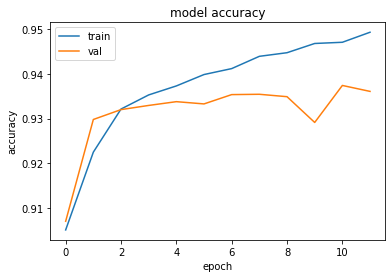

In [274]:
print(model.history.history.keys())
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Результат близок к бейзлайну, но всё равно хуже

##Использование нескольких видов эмбедингов в одной модели - 1.75 балла


In [2]:
!pip install eli5
import pandas as pd
import gensim
import numpy as np
import matplotlib.pyplot as plt
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.model_selection import train_test_split
from string import punctuation
from sklearn.model_selection import KFold, train_test_split
from collections import Counter
import gensim
import tensorflow as tf
from sklearn.metrics import *
from sklearn import linear_model
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
import gensim.downloader as api

import re 
from string import punctuation as punct
gdrive = '/gdrive/My Drive/'
path = gdrive + "jigsaw-toxic-comment-train.csv"
quora = pd.read_csv(path)
quora = quora.sample(frac=0.5, random_state=42)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [3]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [4]:
vocab = Counter()

for text in quora.comment_text:
    vocab.update(preprocess(text))

filtered_vocab = set()

for word in vocab:
    if vocab[word] > 4:
        filtered_vocab.add(word)

len(filtered_vocab)
word2id = {'UNK':1, 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [5]:
id2word = {i:word for word, i in word2id.items()}
X = []

for text in quora.comment_text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)


In [6]:
MAX_LEN = max(len(x) for x in X)

In [7]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)
X.shape
y = quora.toxic

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, random_state=42)

In [9]:
w2v = gensim.models.Word2Vec([preprocess(text) for text in quora.comment_text], size=100)

In [10]:
ft = gensim.models.FastText([preprocess(text) for text in quora.comment_text], size=100)

In [11]:
glove = api.load("glove-wiki-gigaword-100") # 2 модели обучим, а glove возьмем предобученную

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [12]:
w2v_weights = np.zeros((len(w2v.wv.vocab)+2, 100))
for i, vec in enumerate(w2v.wv.vectors): 
  w2v_weights[i+2] = w2v.wv[id2word[i+2]]  

In [13]:
ft_weights = np.zeros((len(ft.wv.vocab)+2, 100))
for i, vec in enumerate(ft.wv.vectors):
  ft_weights[i+2] = ft.wv[id2word[i+2]]

In [14]:
glove_weights = np.zeros((len(ft.wv.vocab)+2, 100))
for i, vec in enumerate(ft.wv.vectors): 
  try:
    glove_weights[i+2] = glove.wv[id2word[i+2]]
  except KeyError:
    glove_weights[i+2] = 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.


In [15]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.weights', 
                                                monitor='val_accuracy',
                                                verbose=1,
                                                save_weights_only=True,
                                                save_best_only=True,
                                                mode='max',
                                                save_freq='epoch')

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                              min_delta=0.01, 
                                              patience=5,
                                              verbose=1, 
                                              mode='max',
                                              )

In [16]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embedding1 = tf.keras.layers.Embedding(input_dim=len(w2v_weights), output_dim=100, weights=[w2v_weights])(inputs)
embedding2 = tf.keras.layers.Embedding(input_dim=len(ft_weights), output_dim=100, weights=[ft_weights])(inputs)
embedding3 = tf.keras.layers.Embedding(input_dim=len(glove_weights), output_dim=100, weights=[ft_weights])(inputs)
embeddings = tf.keras.layers.Concatenate()([embedding1, embedding2, embedding3])
convs = []

conv1 = tf.keras.layers.Conv1D(kernel_size=2, filters=24, strides=1)(embeddings)
conv2 = tf.keras.layers.Conv1D(kernel_size=1, filters=16, strides=1, activation='relu')(conv1)
pool1 = tf.keras.layers.GlobalMaxPooling1D()(conv2)
drop1 = tf.keras.layers.Dropout(0.2)(pool1)
convs.append(drop1)


conv3 = tf.keras.layers.Conv1D(kernel_size=4, filters=32, strides=1)(embeddings)
conv4 = tf.keras.layers.Conv1D(kernel_size=2, filters=28, strides=1)(conv3)
conv5 = tf.keras.layers.Conv1D(kernel_size=1, filters=16, strides=1)(conv4)
pool2 = tf.keras.layers.GlobalMaxPooling1D()(conv5)
convs.append(pool2)

conv6 = tf.keras.layers.Conv1D(kernel_size=5, filters=16, strides=1)(embeddings)
conv7 = tf.keras.layers.Conv1D(kernel_size=3, filters=14, strides=1)(conv6)
conv8 = tf.keras.layers.Conv1D(kernel_size=2, filters=16, strides=1)(conv7)
drop2 = tf.keras.layers.GlobalMaxPooling1D()(conv8)
convs.append(drop2)

conv9 = tf.keras.layers.Conv1D(kernel_size=6, filters=32, strides=1)(embeddings)
conv10 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(conv9)
conv11 = tf.keras.layers.Conv1D(kernel_size=4, filters=32, strides=1)(conv10)
conv12 = tf.keras.layers.Conv1D(kernel_size=3, filters=16, strides=1)(conv11)
drop3 = tf.keras.layers.GlobalMaxPooling1D()(conv12)
convs.append(drop3)


concat = tf.keras.layers.concatenate(convs)

dense = tf.keras.layers.Dense(64, activation='relu')(concat)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=5,
          callbacks = [checkpoint, early_stop])

Epoch 1/5
107/107 [==============================] - ETA: 0s - loss: 0.2448 - accuracy: 0.9208 
Epoch 00001: val_accuracy improved from -inf to 0.93827, saving model to model.weights
107/107 [==============================] - 5233s 49s/step - loss: 0.2448 - accuracy: 0.9208 - val_loss: 0.1675 - val_accuracy: 0.9383
Epoch 2/5
107/107 [==============================] - ETA: 0s - loss: 0.1478 - accuracy: 0.9444 
Epoch 00002: val_accuracy improved from 0.93827 to 0.94847, saving model to model.weights
107/107 [==============================] - 5223s 49s/step - loss: 0.1478 - accuracy: 0.9444 - val_loss: 0.1384 - val_accuracy: 0.9485
Epoch 3/5
107/107 [==============================] - ETA: 0s - loss: 0.1279 - accuracy: 0.9509 
Epoch 00003: val_accuracy improved from 0.94847 to 0.95062, saving model to model.weights
107/107 [==============================] - 5316s 50s/step - loss: 0.1279 - accuracy: 0.9509 - val_loss: 0.1318 - val_accuracy: 0.9506
Epoch 4/5
 62/107 [================>.......

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=800,
         epochs=5,
          callbacks = [checkpoint, early_stop])

In [1]:
print(model.history.history.keys())
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

NameError: ignored